In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist
import scipy.stats
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


# 公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。




## 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


[models/tutorials at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/tutorials)

### 【問題1】解答

**回帰：燃費を予測する**

https://www.tensorflow.org/tutorials/keras/regression

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/FUZZY/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

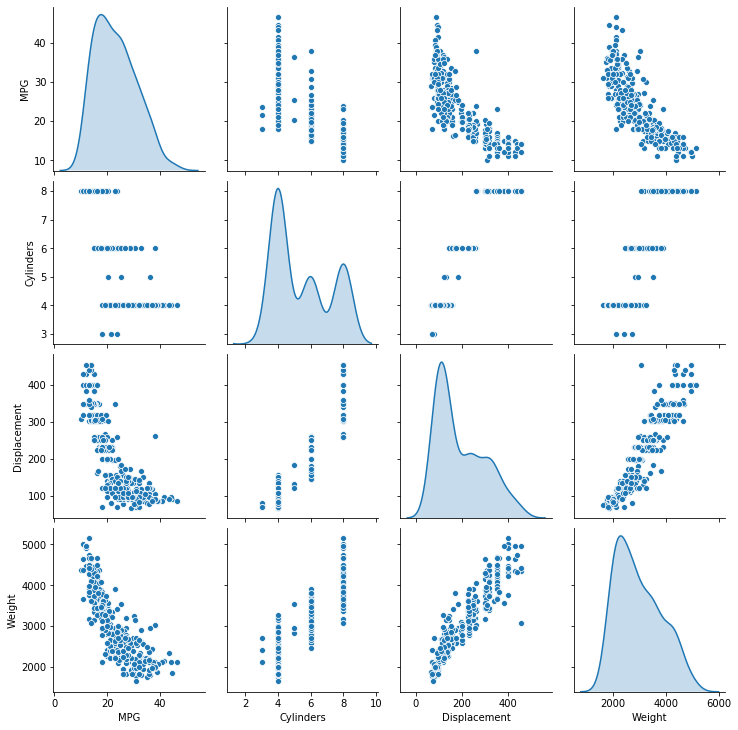

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.19708836],
       [ 0.12030533],
       [ 0.69894856],
       [ 0.11746578],
       [ 0.30319488],
       [ 0.11092096],
       [ 0.37236586],
       [ 0.3683357 ],
       [ 0.13296875],
       [ 0.38161376]], dtype=float32)

In [18]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

# hist.history

In [19]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.101859,0.893643,2.101858,8.140446,2.230258,8.140447,995
996,2.057557,0.909155,2.057557,7.901653,2.225383,7.901653,996
997,2.129098,0.919527,2.129098,7.967730,2.239019,7.967730,997
998,2.450024,1.029925,2.450024,8.298455,2.261784,8.298454,998
999,2.192730,0.902279,2.192729,8.743384,2.317359,8.743384,999


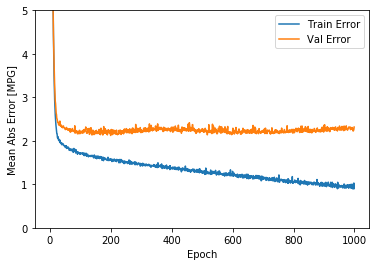

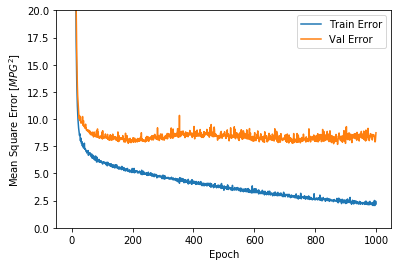

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
...............

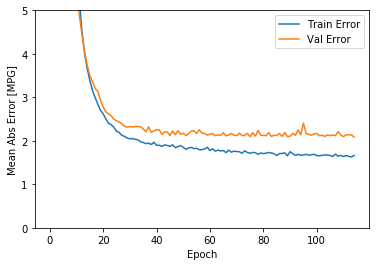

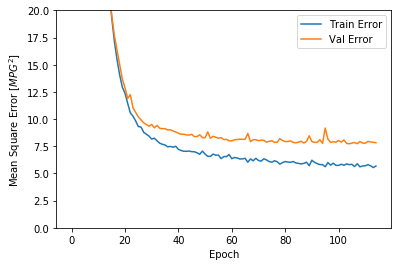

In [22]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9446 - mae: 1.9258 - mse: 5.9446
Testing set Mean Abs Error:  1.93 MPG


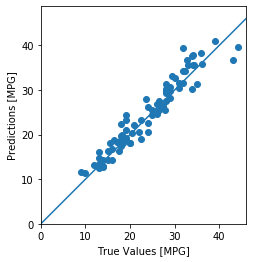

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

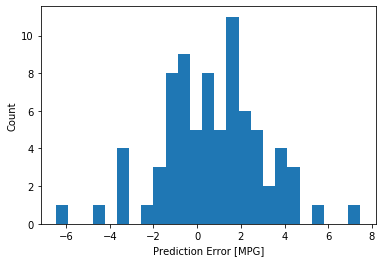

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。


* Iris（Iris-versicolorとIris-virginicaのみの2値分類）
* Iris（3種類全ての目的変数を使用して多値分類）
* House Prices
* MNIST

## Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。


KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。



## 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [26]:
# データセットの読み込み
from sklearn.datasets import load_iris
iris_data = load_iris()
X = iris_data.data[50:]
y = iris_data.target[50:] - 1
print(y.shape)
y = y.astype(np.int)[:, np.newaxis]
print(y.shape)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

(100,)
(100, 1)


In [27]:
model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=4, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

# モデルの学習
## batch_size:サブセットに含まれるデータの数
## verbose:学習進捗度合いを出力 0 = silent, 1 = progress bar, 2 = one line per epoch
## epochs:データセットで行う学習の回数
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size=10, verbose=1, epochs=30)

print(history.history.keys())

# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________
Train on 51 samples, validate on 13 samples
Epoch 1/30
51/51 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4902 - val_loss: 0.6874 - val_accuracy: 0.7692
Epoch 2/30
51/51 [==============================] - 0s 200us/ste

## 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [28]:
# データセットの読み込み
from sklearn.datasets import load_iris
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:, np.newaxis])

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [29]:
# サマリーグラフのクリア
K.clear_session()

model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=4, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(3, activation="softmax", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(history.history.keys())


# モデルの学習
## batch_size:サブセットに含まれるデータの数
## verbose:学習進捗度合いを出力 0 = silent, 1 = progress bar, 2 = one line per epoch
## epochs:データセットで行う学習の回数
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size=10, verbose=1, epochs=30)

history.history.keys()

# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])
Train on 76 samples, validate on 20 samples
Epoch 1/30
76/76 [==============================] - 0s 2ms/step - loss: 1.0960 - accuracy: 0.3289 - val_loss: 1.0902 - val_accuracy: 0.2500
Epoch 2/30
76/76 [==============================] - 0s 211us/step - loss: 1.0719 - accuracy: 0.4605 - val_loss: 1.0613 - val_accuracy: 0.6500
Epoch 3/30
76/76 [==============================] - 0s 151us/step - loss: 1.0155 - accuracy: 0.6974 - val_loss: 0.9922 - val_accuracy: 0.6500
Epoch 4/30
76/76 [==============================] - 0s 146us/step - loss: 0.9012 - accuracy: 0.6974 - val_loss: 0.8544 - val_accuracy: 0.6500
Epoch 5/30
76/76 [==============================] - 0s 153us/step - loss: 0.7261 - accuracy: 0.6974 - val_loss: 0.6836 - val_accuracy: 0.6500
Epoch 6/30
76/76 [==============================] - 0s 164us/step - loss: 0.5654 - accuracy: 0.6974 - val_loss: 0.5129 - val_accuracy: 0.6500
Epoch 7/30
76/76 [============================

## 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [30]:
df= pd.read_csv('../house-prices-advanced-regression-techniques/train.csv')
X = df[['GrLivArea', 'YearBuilt']]
y = df.SalePrice[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 正規化
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std



# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train.shape

(934, 2)

In [31]:
# サマリーグラフのクリア
K.clear_session()

model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=2, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(1))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

model.summary()

# モデルの学習
## batch_size:サブセットに含まれるデータの数
## verbose:学習進捗度合いを出力 0 = silent, 1 = progress bar, 2 = one line per epoch
## epochs:データセットで行う学習の回数
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size=10, verbose=1, epochs=30)

print(history.history.keys())

# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________
Train on 747 samples, validate on 187 samples
Epoch 1/30
747/747 [==============================] - 0s 285us/step - loss: 39879596544.6854 - mae: 182820.5469 - val_loss: 36716869467.7219 - val_mae: 176018.6875
Epoch 2/30
747/747 [==================

## 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [32]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape

(48000, 28, 28, 1)

In [33]:
# サマリーグラフのクリア
K.clear_session()

model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Conv2D(128, input_shape=(28, 28, 1), kernel_size=(3, 3), activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(MaxPool2D(pool_size=(2, 2)))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Flatten())

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(10, activation="softmax", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

# モデルの学習
## batch_size:サブセットに含まれるデータの数
## verbose:学習進捗度合いを出力 0 = silent, 1 = progress bar, 2 = one line per epoch
## epochs:データセットで行う学習の回数
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size=20, verbose=1, epochs=5)

print(history.history.keys())

# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                216330    
Total params: 217,610
Trainable params: 217,610
Non-trainable params: 0
_________________________________________________________________
Train on 38400 samples, validate on 9600 samples
Epoch 1/5
38400/38400 [==============================] - 15s 398us/step - loss: 0.1945 - accuracy: 0.9413 - val_loss: 0.0915 - val_accuracy: 0.9724
Epoch 2/5
38400/38400 [==========================